# Forecasting the outflow of telecom company customers

## Problem statement

Based on payment history and user data, we need to build a model that identifies potential leavers with an AUC-ROC of 0.85 or higher. The model does not estimate quit times, but predicts current customer status based on available data. The model must be developed, tested and described by November 3, 2022.

## Problem solution plan

<ol>
     <li>Getting familiarized with the input data</li>
     <ol>
         <li>Read data</li>
         <li>Check for correctness (check logic violations, outliers)</li>
         <li>Check data connectivity (if they are not represented by a single table)</li>
     </ol>
     <li>Data preprocessing</li>
     <ol>
         <li>Fill in missing values</li>
         <li>Correct data to more appropriate types if possible</li>
         <li>Explore feature correlation (to correctly determine the set of features depending on the model)</li>
         <li>Add synthetic features - whether the client left or not, how long he was a client</li>
         <li>Remove irrelevant features (For example, the user ID does not affect the decision to terminate the contract)</li>
     </ol>
     <li>Research signs and build a profile(s) of exiting users</li>
     <ol>
         <li>Study the distribution of monthly payments (for everyone and for those who left)</li>
         <li>Distribution of users by tariffs / communication services (for all and for those who left)</li>
         <li>Research how often clients renegotiate a contract (annual contract expired - extended for next year)</li>
         <li>If there are traits clearly correlated with leaving, build distributions based on their values</li>
     </ol>
     <li>Build models and cross-validate AUC-ROC metric
     <ol>
         <li>Decision Tree</li>
         <li>Linear regression</li>
         <li>CatBoost gradient boosting</li>
     </ol>
     <li>Analyze optimal model</li>
     <ol>
         <li>For the optimal model, check on the test sample with the calculation of the accuracy metric</li>
         <li>Display a list of the most important features (with large weights in the model)</li>
         <li>Construct payment size distribution charts, distribution of users by tariffs/communication services for those customers of the test sample whom the model considers "leaving" (that is, get a portrait of the departing according to the model version)</li>
     </ol>
     <li>Generate progress report</li>
     <ol>
         <li>Indicate which features and model were the most effective</li>
         <li>Compare the expected portrait of the departing person with the received portrait "according to the model"</li>
         <li>Based on the constructed distributions and the obtained predictions, give a recommendation on customer retention</li>
     </ol>
</ol>

## Setup tools

Before we start, let's create a code cells to download extra libraries and import everything we need to solve the problem. It will be replenished in the course of the solution.

### Install libraries

In [1]:
!pip install -q phik
!pip install -q category_encoders

### Import libraries and frameworks 

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import phik
import json
import category_encoders as ce
import seaborn as sb

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from phik.report import plot_correlation_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, Pool


import warnings
warnings.filterwarnings("ignore")

### Define constants

In [27]:
RANDOM_STATE=271022
TEST_SIZE=0.25
CV=5

### Define functions

To load data, let's define the load_df function, which will either load the file in the current directory (for local work) or on the path for the simulator.

In [28]:
def load_df(filename):
    try:
        return pd.read_csv(os.path.join("/datasets/final_provider", filename))
    except:
        return pd.read_csv(filename)    

Function that shows info and first 5 rows of dataframe.

In [29]:
def show_df(df):
    display(df.info())
    display(df.head(5))

## Read data

In [30]:
personal_df = load_df('personal.csv')
contract_df = load_df('contract.csv')
internet_df = load_df('internet.csv')
phone_df = load_df('phone.csv')

Now we should check each dataframe for missing values and data types, one by one.

In [17]:
show_df(personal_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [18]:
show_df(contract_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


TotalCharges column data type expected to be float64, same as MonthlyCharges. We have to check values in TotalCharges.

In [31]:
display(contract_df['TotalCharges'].sort_values().head(15))
display(contract_df[contract_df['TotalCharges'].str.strip() == ''])

936           
3826          
4380          
753           
5218          
3331          
6754          
6670          
1340          
488           
1082          
105      100.2
4459    100.25
1723    100.35
2124     100.4
Name: TotalCharges, dtype: object

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


All missing values in TotalCharges can be explained - the data is collected for the period up to 2020-02-01, i.e. these users have never been charged yet. In the preprocessing section let's fill in gaps 0. We could use MonthlyCharges value, but it is "unphysical" - month has not yet passed, and if we consider that month passed, then "extreme" date (to calculate duration of contracts) is 2020-03-01, and then we need 1 month "solve for the client", that is to distort the whole dataset.
We also have to create synthetic attributes broken (whether the contract was broken) and contract duration (as a difference of BeginDate and EndDate). We will interpret the value "Not" in the dataset as 2020-02-01.

In [20]:
show_df(internet_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [21]:
show_df(phone_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


## Preprocessing data

To fill gaps and assign proper data types, we need to apply next transformations:<br>
<ul>
<li>contract</li>
<ol>
    <li>TotalCharges - fill empty strings and missed values with "0"</li>
    <li>TotalCharges - convert to float64</li>
    <li>EndDate - replace "No" to "2020-02-01", convert to datetime</li>
    <li>BeginDate - convert to datetime</li>
    <li>duration - compute as EndDate - BeginDate</li>
    <li>broken - synthetic boolean feature, equal "1" if contract was broken, else "0"</li>
</ol>
<li>internet</li>
<ol>
    <li>isInternet - feature shows, that client uses internet</li>
</ol>
<li>phone</li>
<ol>
    <li>isPhone - feature shows, that client uses phone</li>
</ol>
<li>personal</li>
<ol>
    <li>SeniorCitizen - replace "1" and "0" values to "Yes" and "No" accordingly, so it will more "readable" and used as category</li>
</ol>
</ul>

### Contract

In [32]:
[*contract_df.loc[contract_df['EndDate'] != "No",'EndDate'].unique()]

['2019-12-01 00:00:00',
 '2019-11-01 00:00:00',
 '2019-10-01 00:00:00',
 '2020-01-01 00:00:00']

Clients started to leave in 2019-10-01

In [33]:
contract_df.loc[contract_df['TotalCharges'].str.strip() == '', 'TotalCharges'] = 0
contract_df.loc[contract_df['EndDate'] == "No", 'EndDate'] = '2020-02-01 00:00:00'
contract_df['EndDate'] = pd.to_datetime(contract_df['EndDate'], format='%Y-%m-%d %H:%M:%S')
contract_df['BeginDate'] = pd.to_datetime(contract_df['BeginDate'], format='%Y-%m-%d')
contract_df['TotalCharges'] = contract_df['TotalCharges'].astype('float64')
contract_df['duration'] = contract_df['EndDate'] - contract_df['BeginDate']
contract_df['broken'] = contract_df['EndDate'] < '2020-02-01'
contract_df['duration'] = contract_df['duration'].dt.days

Lets check dataframe with slice1: EndDate = '2020-02-01' and slice2: EndDate < '2020-02-01', so we can check if synthetic features were made correctly.

In [34]:
display(contract_df[contract_df['EndDate']== '2020-02-01'].head(5))
display(contract_df[contract_df['EndDate'] < '2020-02-01'].head(5))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,duration,broken
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,31,False
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,1036,False
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,1371,False
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,671,False
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,301.90,306,False


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,duration,broken
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,61,True
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,61,True
5,9305-CDSKC,2019-03-01,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50,245,True
8,7892-POOKP,2017-07-01,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05,853,True
13,0280-XJGEX,2015-09-01,2019-10-01,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,1491,True


We drop BeginDate and EndDate, because we cant use them as features (or they become leakage).

In [35]:
contract_df = contract_df.drop(['BeginDate', 'EndDate'], axis=1)
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   object 
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7043 non-null   float64
 6   duration          7043 non-null   int64  
 7   broken            7043 non-null   bool   
dtypes: bool(1), float64(2), int64(1), object(4)
memory usage: 392.2+ KB


### Internet

In [36]:
internet_df['isInternet'] = "Yes"
show_df(internet_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
 8   isInternet        5517 non-null   object
dtypes: object(9)
memory usage: 388.0+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,isInternet
0,7590-VHVEG,DSL,No,Yes,No,No,No,No,Yes
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No,Yes
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No,Yes
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No,Yes
4,9237-HQITU,Fiber optic,No,No,No,No,No,No,Yes


### Phone

In [37]:
phone_df['isPhone'] = "Yes"
show_df(phone_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
 2   isPhone        6361 non-null   object
dtypes: object(3)
memory usage: 149.2+ KB


None

,customerID,MultipleLines,isPhone
0,5575-GNVDE,No,Yes
1,3668-QPYBK,No,Yes
2,9237-HQITU,No,Yes
3,9305-CDSKC,Yes,Yes
4,1452-KIOVK,Yes,Yes


### personal

In [38]:
personal_df['SeniorCitizen'] = personal_df['SeniorCitizen'].astype('str')
personal_df.loc[personal_df['SeniorCitizen'] == '1', 'SeniorCitizen'] = "Yes"
personal_df.loc[personal_df['SeniorCitizen'] == '0', 'SeniorCitizen'] = "No"

### Merge tables

In [39]:
df = personal_df.merge(phone_df,    how='outer', on='customerID')\
                .merge(internet_df, how='outer', on='customerID')\
                .merge(contract_df, how='outer', on='customerID')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   MultipleLines     6361 non-null   object 
 6   isPhone           6361 non-null   object 
 7   InternetService   5517 non-null   object 
 8   OnlineSecurity    5517 non-null   object 
 9   OnlineBackup      5517 non-null   object 
 10  DeviceProtection  5517 non-null   object 
 11  TechSupport       5517 non-null   object 
 12  StreamingTV       5517 non-null   object 
 13  StreamingMovies   5517 non-null   object 
 14  isInternet        5517 non-null   object 
 15  Type              7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


NA values in merged dataframe means, that some users use only internet or only phone (but not both). If user doesnt have internet, fill NA with False. Also apply same strategy to MultipleLines for phone data - if user doesnt have phone, he cant use multiple phone lines.
Finally, we can drop. customerID, because it's not a feature.

In [40]:
df.fillna("No", inplace=True)
df.drop('customerID', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   object 
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   MultipleLines     7043 non-null   object 
 5   isPhone           7043 non-null   object 
 6   InternetService   7043 non-null   object 
 7   OnlineSecurity    7043 non-null   object 
 8   OnlineBackup      7043 non-null   object 
 9   DeviceProtection  7043 non-null   object 
 10  TechSupport       7043 non-null   object 
 11  StreamingTV       7043 non-null   object 
 12  StreamingMovies   7043 non-null   object 
 13  isInternet        7043 non-null   object 
 14  Type              7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


## Examine features and compiling a portrait of leaving client

Let's calculate the percentage of clients who left (by month).

In [41]:
print("{:d}/{:d} clients left, percentage: ({:.2f}%)".format(df['broken'].sum(),
                                                    df['broken'].count(),
                                                    100*df['broken'].mean()))

1869/7043 clients left, percentage: (26.54%)


Compare statistics of monthly charges for whole dataset and for clients, who left.

In [42]:
amc = df['MonthlyCharges'].to_numpy() # all monthly charges
bmc = df.loc[df['broken']==1, 'MonthlyCharges'].to_numpy() # broken monthly charges
print("Total  | MIN {:.2f} | MAX {:.2f} | AVG {:.2f} | Q25 {:.2f} | Q50 {:.2f} | Q75 {:.2f}".format(
    amc.min(), amc.max(), amc.mean(), np.quantile(amc, 0.25), np.quantile(amc,0.5), np.quantile(amc,0.75))
     )
print("Broken | MIN {:.2f} | MAX {:.2f} | AVG {:.2f} | Q25 {:.2f} | Q50 {:.2f} | Q75 {:.2f}".format(
    bmc.min(), bmc.max(), bmc.mean(), np.quantile(bmc, 0.25), np.quantile(bmc,0.5), np.quantile(bmc,0.75))
)

Total  | MIN 18.25 | MAX 118.75 | AVG 64.76 | Q25 35.50 | Q50 70.35 | Q75 89.85
Broken | MIN 18.85 | MAX 118.35 | AVG 74.44 | Q25 56.15 | Q50 79.65 | Q75 94.20


We can see, that clients who left, payed more (difference in mean monthly charge is 9.7, difference in median is 9.3)

[Text(0.5, 1.0, 'Distribution of Monthly Charges for all users'), (10.0, 120.0)]


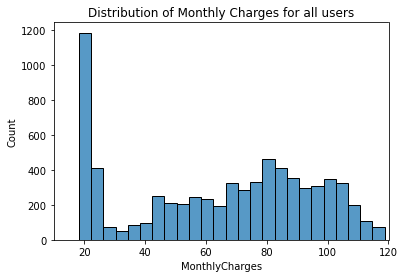

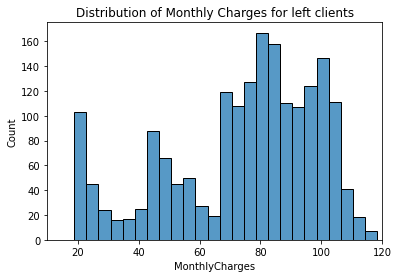

In [76]:
sb.histplot(data=df['MonthlyCharges'], bins=25).set(title="Distribution of Monthly Charges for all users", xlim=(10,120))
plt.figure();
sb.histplot(data=df.loc[df['broken']==1, 'MonthlyCharges'], bins=25).set(title="Distribution of Monthly Charges for left clients", xlim=(10,120))

Among the clients who left, we can see a peak of about 20, 45 and a "hump" with a peak of about 80. Most likely, the peaks are related to the tariff network and more popular sets of additional services. Let's build for each group the distribution according to the type of connection (Internet/telephone)

<Figure size 432x288 with 0 Axes>

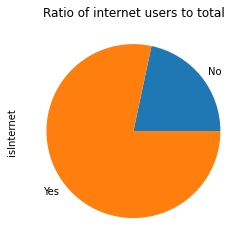

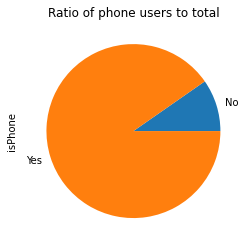

<Figure size 432x288 with 0 Axes>

In [78]:
df.groupby('isInternet')['isInternet'].count().plot.pie(title='Ratio of internet users to total')
plt.figure()
df.groupby('isPhone')['isPhone'].count().plot.pie(title='Ratio of phone users to total')
plt.figure()

In [79]:
print(df.groupby('isInternet')['isInternet'].count())
print(df[df['broken']==1].groupby('isInternet')['isInternet'].count())

isInternet
No     1526
Yes    5517
Name: isInternet, dtype: int64
isInternet
No      113
Yes    1756
Name: isInternet, dtype: int64


<Figure size 432x288 with 0 Axes>

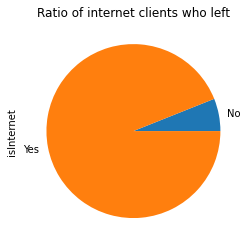

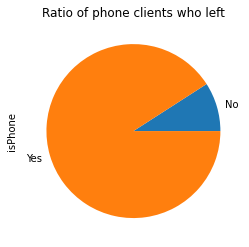

<Figure size 432x288 with 0 Axes>

In [80]:
df[df['broken']==1].groupby('isInternet')['isInternet'].count().plot.pie(title='Ratio of internet clients who left')
plt.figure()
df[df['broken']==1].groupby('isPhone')['isPhone'].count().plot.pie(title='Ratio of phone clients who left')
plt.figure()

The graphs above show that the share of Internet users among the users who left is higher than in the overall statistics. In the case of landline users, the shares are about the same. It can be assumed that Internet users are dissatisfied with the ratio of price to services provided.<br>
Now let's examine the share of users of which services decreased and how the departure affected the users who used both the phone and the Internet.

In [82]:
print("Both internet and phone | Left {:d} / {:d}".format(
    df[(df['isInternet'] == "Yes") &
       (df['isPhone']=="Yes") &
       (df['broken'] == 1)].shape[0],
    df[(df['isInternet'] == "Yes") &
       (df['isPhone']=="Yes")].shape[0],
))

Both internet and phone | Left 1586 / 4835


An interesting observation is that a total of 1,869 customers out of 7,043 left, with 1,586 who left using both landline and Internet service.

,OnlineBackup,OnlineSecurity,DeviceProtection,StreamingTV,StreamingMovies,TechSupport
No,29.2,31.3,28.7,24.3,24.4,31.2
Yes,21.5,14.6,22.5,30.1,29.9,15.2


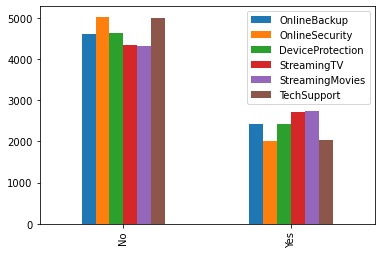

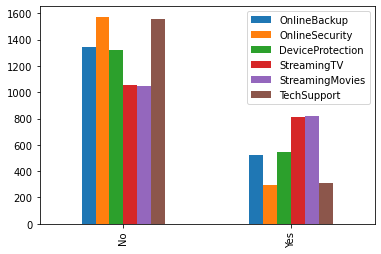

In [87]:
services_all = df.loc[:,['OnlineBackup', 'OnlineSecurity', 'DeviceProtection',
                'StreamingTV', 'StreamingMovies', 'TechSupport']].apply(pd.Series.value_counts)
services_leave = df.loc[df['broken']==1, [
    'OnlineBackup', 'OnlineSecurity', 'DeviceProtection',
    'StreamingTV', 'StreamingMovies', 'TechSupport']].apply(pd.Series.value_counts)

services_all.plot(kind='bar')
services_leave.plot(kind='bar')
display(round(100*services_leave/services_all, 1))

We can see, that almost 1/3 users of StreamingTV and StreamingMovies left.<br>
Lets look how kids, family and age can influence on client behaviour.

,SeniorCitizen,Dependents,Partner
No,23.6,31.3,33.0
Yes,41.7,15.5,19.7


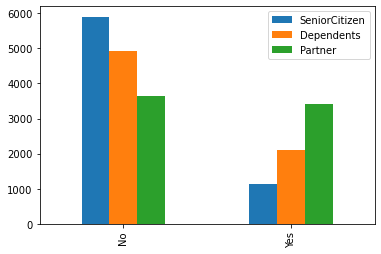

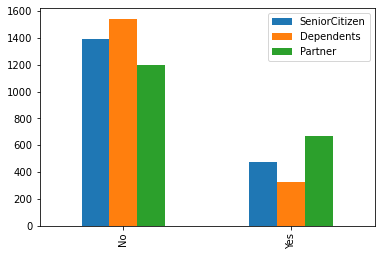

In [88]:
services_all = df.loc[:,
               ['SeniorCitizen', 'Dependents', 'Partner']].apply(pd.Series.value_counts)
services_leave = df.loc[df['broken']==1,
                        ['SeniorCitizen', 'Dependents', 'Partner']].apply(pd.Series.value_counts)
services_all.plot(kind='bar')
services_leave.plot(kind='bar')
display(round(100*services_leave/services_all, 1))

The proportion of the elderly among those leaving is noticeably higher than in the overall statistics.

So, the outgoing client, as a rule:
<ul>
<li>Pays more (there is shift in average and median monthly charge)</li>
<li>Uses both the Internet and a telephone connection</li>
<li>Usually have a package of Internet services includes StreamingTV and StreamingMovies</li>
<li>Approximately one in four of those who leave belong to the group SeniorCitizen(retired)</li>
</ul>

## Model construction and analysis

### Preparing features

To build models and analyze them, it is necessary to remove unnecessary data and eliminate the risk of data leakage. We remove isPhone and isInternet columns.

In [89]:
df.drop(columns=['isInternet', 'isPhone'], axis=1, inplace=True)

In [90]:
df.head(10)

,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,duration,broken
0,Female,No,Yes,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,31,False
1,Male,No,No,No,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,1036,False
2,Male,No,No,No,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,61,True
3,Male,No,No,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,1371,False
4,Female,No,No,No,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,61,True
5,Female,No,No,No,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,245,True
6,Male,No,No,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,671,False
7,Female,No,No,No,No,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.90,306,False
8,Female,No,Yes,No,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,853,True
9,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,1888,False


Lets build correlation matrix with PhiK.

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'duration']


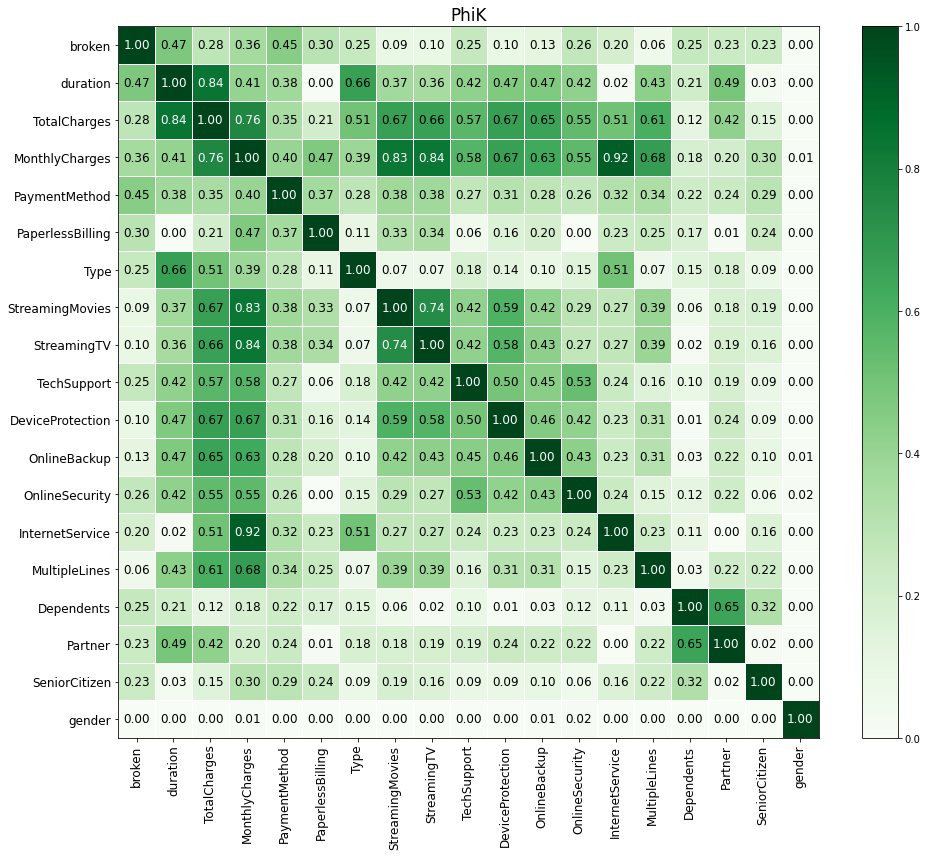

In [91]:
corrMatrix = df.phik_matrix()

plot_correlation_matrix(corrMatrix.values,
                        x_labels=corrMatrix.columns,
                        y_labels=corrMatrix.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"PhiK",
                        fontsize_factor=1.2,
                        figsize=(14, 12))
plt.tight_layout()

Let's highlight a few parameters that can be excluded.
<ul>
    <li>gender - zero correlation with all other parameters, including the target</li>
    <li>TotalCharges - strong correlation with MonthCharges and duration</li>
    <li>StreamingMovies - seems like multicollinearity with StreamingTV</li>
    <li>OnlineBackup - seems like multicollinearity with DeviceProtection</li>
</ul>
The similar "behavior" of the traits (the same correlation with other parameters) can be interpreted as their multicollinearity and a chance to lower the dimensionality of the incoming data.

In [92]:
df.drop(inplace=True, columns=['TotalCharges', 'StreamingMovies', 'OnlineBackup', 'gender'], axis=1)

### Extract features and target

In [93]:
features = df.drop('broken', axis=1)
target = df['broken']
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SeniorCitizen     7043 non-null   object 
 1   Partner           7043 non-null   object 
 2   Dependents        7043 non-null   object 
 3   MultipleLines     7043 non-null   object 
 4   InternetService   7043 non-null   object 
 5   OnlineSecurity    7043 non-null   object 
 6   DeviceProtection  7043 non-null   object 
 7   TechSupport       7043 non-null   object 
 8   StreamingTV       7043 non-null   object 
 9   Type              7043 non-null   object 
 10  PaperlessBilling  7043 non-null   object 
 11  PaymentMethod     7043 non-null   object 
 12  MonthlyCharges    7043 non-null   float64
 13  duration          7043 non-null   int64  
dtypes: float64(1), int64(1), object(12)
memory usage: 1.1+ MB


Let's divide the sample into training and test samples, and apply CatBoostEncoder and StandardScaler to training set. We will encode all columns except MonthlyCharges and duration (they should be scaled). 

In [94]:
num_cols = ['MonthlyCharges', 'duration']
cat_cols = [x for x in features.columns if x not in num_cols]

In [95]:
train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=target)
cbe_encoder = ce.cat_boost.CatBoostEncoder()
cbe_encoder.fit(train_features[cat_cols], train_target)
train_features[cat_cols] = cbe_encoder.transform(train_features[cat_cols])
scaler = StandardScaler()
scaler.fit(train_features[num_cols])
train_features[num_cols] = scaler.transform(train_features[num_cols])

### Decision Tree Classifier

In [96]:
models = pd.DataFrame(index=['DecisionTree', 'LogisticRegression','CatBoost'],
                      columns=['params','AUC-ROC'])
tree = DecisionTreeClassifier()
tree_params = [{'max_depth': list(range(2, 20)),
                'max_features': list(range(1, 15))
                }]
clf = GridSearchCV(tree, tree_params, cv=CV, scoring='roc_auc')
clf.fit(train_features, train_target)
models.loc['DecisionTree', 'params'] = json.dumps(clf.best_params_)
models.loc['DecisionTree', 'AUC-ROC'] = clf.best_score_

{'max_depth': 6, 'max_features': 14}
AUC-ROC 0.8526278734427329


### Logistic Regression

In [97]:
log_reg = LogisticRegression()
log_reg_params = [{
    'max_iter': [100, 500, 1000],
    'class_weight': [None, 'balanced'],
}]
clf = GridSearchCV(log_reg, log_reg_params, cv=CV, scoring='roc_auc')
clf.fit(train_features, train_target)
models.loc['LogisticRegression', 'params'] = json.dumps(clf.best_params_)
models.loc['LogisticRegression', 'AUC-ROC'] = clf.best_score_

{'class_weight': 'balanced', 'max_iter': 100}
AUC-ROC 0.8401378282905047


### CatBoost

In [115]:
train_dataset = Pool(train_features, train_target) #, cat_features=categorical_indicies)
cbc = CatBoostClassifier(loss_function='Logloss',
                         eval_metric='AUC:hints=skip_train~false',
                         logging_level='Silent',
                        )
cbc_params = {'depth': list(range(2, 15)),
              'learning_rate': list(np.arange(0.1, 1.1, 0.3)),
              'iterations': [100,]
}
grid_search_result = cbc.grid_search(cbc_params, train_dataset, cv=CV)
models.loc['CatBoost','params'] = json.dumps(grid_search_result['params'])
models.loc['CatBoost','AUC-ROC'] = max(grid_search_result['cv_results']['test-AUC-mean'])

0:	loss: 0.8627620	best: 0.8627620 (0)	total: 176ms	remaining: 8.99s
1:	loss: 0.8921238	best: 0.8921238 (1)	total: 315ms	remaining: 7.87s
2:	loss: 0.9073965	best: 0.9073965 (2)	total: 473ms	remaining: 7.72s
3:	loss: 0.9102362	best: 0.9102362 (3)	total: 632ms	remaining: 7.58s
4:	loss: 0.8645741	best: 0.9102362 (3)	total: 826ms	remaining: 7.76s
5:	loss: 0.8984808	best: 0.9102362 (3)	total: 978ms	remaining: 7.5s
6:	loss: 0.9062731	best: 0.9102362 (3)	total: 1.14s	remaining: 7.3s
7:	loss: 0.9043652	best: 0.9102362 (3)	total: 1.32s	remaining: 7.24s
8:	loss: 0.8695112	best: 0.9102362 (3)	total: 1.59s	remaining: 7.58s
9:	loss: 0.8988352	best: 0.9102362 (3)	total: 1.87s	remaining: 7.86s
10:	loss: 0.9019668	best: 0.9102362 (3)	total: 2.24s	remaining: 8.36s
11:	loss: 0.9058117	best: 0.9102362 (3)	total: 2.6s	remaining: 8.68s
12:	loss: 0.8686107	best: 0.9102362 (3)	total: 3s	remaining: 9.01s
13:	loss: 0.8956054	best: 0.9102362 (3)	total: 3.39s	remaining: 9.2s
14:	loss: 0.8915710	best: 0.9102362 (

Display pivot table with AUC-ROC and optimal params for each model.

In [116]:
pd.set_option('display.max_colwidth', None)
display(models.sort_values('AUC-ROC', ascending=False))

,params,AUC-ROC
CatBoost,"{""depth"": 2, ""iterations"": 100, ""learning_rate"": 1.0000000000000002}",0.915257
DecisionTree,"{""max_depth"": 6, ""max_features"": 14}",0.852628
LogisticRegression,"{""class_weight"": ""balanced"", ""max_iter"": 100}",0.840138


### Run best model on test data

Best result was reached with CatBoostClassifier. Lets encode and and scale whole training dataset and compute AUC-ROC и accuracy.

In [106]:
test_features[cat_cols] = cbe_encoder.transform(test_features[cat_cols])
test_features[num_cols] = scaler.transform(test_features[num_cols])
test_dataset = Pool(test_features, test_target) #, cat_features=categorical_indicies)
best_model = CatBoostClassifier(loss_function='Logloss',
                                logging_level='Silent',
                                depth=2,
                                iterations=100,
                                learning_rate=1)
best_model.fit(train_dataset)
predict = best_model.predict_proba(test_dataset)

In [107]:
print("ROC AUC: {:.2f} | ACCURACY: {:.2f}".format(
    roc_auc_score(test_target, predict[:, 1]),
    accuracy_score(test_target, predict[:, 1]>=0.5))
)

ROC AUC: 0.90 | ACCURACY: 0.84


Now we should compare our model to dummy one. Lets compute AUC-ROC and accuracy for dummy model, that always predicts 0 (means that client will stay with company).

In [108]:
dummy_predict = np.zeros(test_target.shape[0])
print("DUMMY ROC AUC: {:.2f} | ACCURACY: {:.2f}".format(
    roc_auc_score(test_target, dummy_predict),
    accuracy_score(test_target, dummy_predict)
))

DUMMY ROC AUC: 0.50 | ACCURACY: 0.73


Lets compare confusion matrix for CatboostClassifier model and dummy one.

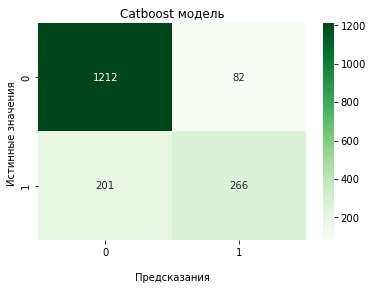

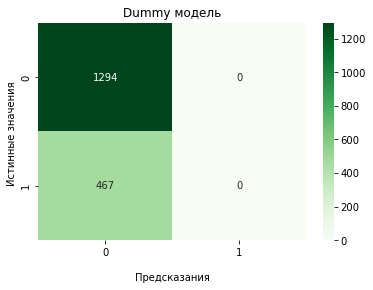

In [109]:
cfm1 = confusion_matrix(test_target, predict[:, 1]>=0.5)
cfm2 = confusion_matrix(test_target, dummy_predict)

ax = sb.heatmap(cfm1, annot=True, fmt='g', cmap='Greens')
ax.set_title('Catboost модель')
ax.set_xlabel('\nПредсказания')
ax.set_ylabel('Истинные значения ')
plt.show()

bx = sb.heatmap(cfm2, annot=True, fmt='g', cmap='Greens')
bx.set_title('Dummy модель')
bx.set_xlabel('\nПредсказания')
bx.set_ylabel('Истинные значения ')
plt.show()

Thus, the model began to recognize clients who are really leaving at the cost of misidentifying clients who are not going to leave. The model gives the probability that the customer in question will leave, but additionally a parameter for the exit probability threshold can be introduced.<br>
Dummy model believes that the chance of the client to leave is 0%, that is, if the model is wrong - there is no way to offer the client better terms and keep it (True Negative counter). <br>
Assuming that any customer can leave, businesses run the risk of mass discounts to spend money to retain customers who are not going to leave (False Positive counter).<br>
The balance between these two classes in the model can be established either by maximizing formal metrics or by establishing the "utility" of retained clients over those who left. Maximizing accuracy, we get the maximum "correct" answer of the model, that is, the set FP + TN clients will be minimal (If they are few, you can offer discounts and specials not automatically, but in manual mode)

In [110]:
for th in np.arange(0.3, 0.95, 0.05):
    print("{:.2f} {:.4f}".format(th, accuracy_score(test_target, predict[:, 1]>=th)))

0.30 0.8245
0.35 0.8427
0.40 0.8416
0.45 0.8438
0.50 0.8393
0.55 0.8393
0.60 0.8370
0.65 0.8342
0.70 0.8313
0.75 0.8223
0.80 0.8126
0.85 0.8007
0.90 0.7922


Thus, the highest prediction accuracy is achieved at a probability threshold of 45%.

With CatBoostClassifier we reached auc_roc=0.9 and accuracy=0.84. Finally, lets analyze feature importance.

In [111]:
param_importance = pd.DataFrame({'weight':best_model.get_feature_importance()},
                                index=test_features.columns)

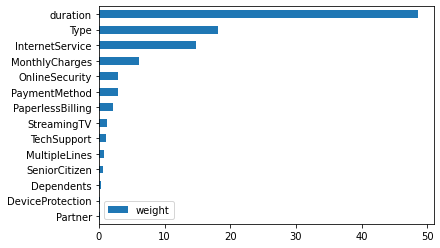

In [49]:
param_importance.sort_values('weight', ascending=True)\
                .plot(kind='barh')

That is, the leading facts were the number of days from the beginning to the end of the contract (or current day), the type of contract, the type of Internet connection and the tariff (monthly payment). Several other factors, such as the possibility of cashless payment, method of payment and some kind of security services, influenced the attitude of users with less weight. Probably, OnlineSecurity was default option, so it become "overweight".

## Report

### Problem description

Telecom operator provides Internet and landline telephone services. Since October 2019 there has been a customer churn, and it takes a week to build a machine learning model that predicts whether a customer will leave or not.

### Input data

The inputs are current and retired customers from October 2013 through February 2020. There is no payment data for new customers contracted in February 2020.
The dataset includes a total of 7,403 customers, of which 1,869 terminated their contract between October 2019 and February 2020.
Dataset is represented by 4 tables that store data about:
<ul>
    <li>phone users,</li>
    <li>internet users,</li>
    <li>personal data, </li>
    <li>concluded contracts and payment information</li>
</ul>
These tables are linked through unique user IDs and all data are interpreted unambiguously.

### Preprocessing

The input data omits payment statistics for new users. Since at the beginning of February 2020 they haven't had time to make any payments yet, it is assumed that the payment statistics are 0.<br>
If the user has not used services and there is no information about him in the corresponding table, the service column is written with the value "No".<br>
The target attribute is a date of rupture of a contract; synthetic target attribute broken (1 if there's a date of rupture, otherwise 0) was introduced for convenience and interpretation of data.<br>
We also introduced a synthetic indicator duration, which is equal to the number of days between the conclusion and termination of the contract. If the client has not terminated the contract, duration is the number of days from contract conclusion to February 1, 2020.

### Client portrait

Internet and landline telephone services with additional services are investigated.
<ul>
<li>Most users (1,586 out of 1,869 who left) used both the Internet and telephone, but the proportion of Internet users among those who left (93.9%) was higher than the overall proportion of Internet users (78.3%).<br>
<img height="500" src="https://i.ibb.co/j66F61x/rate-internet.png"/><br>
<img height="500" src="https://i.ibb.co/5cHQw2v/rate-left-internet.png"/>
</li>
<li>Approximately one in three elderly clients who leave</li>
<li>Among the additional services used by departing customers, the most popular were streaming TV and movies<br>
<img height="500" src="https://i.ibb.co/QNMrRW0/internet-services-left.png"/>
</li>
<li>Average and median monthly payments are 10 higher among outgoing customers relative to all users</li>
<li>Clients of all price categories leave, but more - in the 70-100 segment<br>
<img height="500" src="https://i.ibb.co/yn15Jgz/rate-month-payments-left.png"/>
</li>
</ul>

### Building and choosing a model

From the input data set were excluded:
<ul>
<li>User IDs</li>
<li>Total payments per user</li>
<li>Dates of conclusion and termination of the contract</li>
<li>User gender</li>
<li>Information about additional Internet services - Online Backup and Movie Streaming</li>
</ul>
On the remaining data, the following models were trained and the following AUC target metrics were achieved:
<table>
<tr>
     <td>Model</td>
     <td>Decision tree</td>
     <td>Logistic regression</td>
     <td>CatBoost classifier</td>
</tr>
<tr>
     <td>AUC-ROC</td>
     <td>0.85</td>
     <td>0.84</td>
     <td>0.91</td>
</tr>
</table>
The CatBoost model showed the highest result of the target metric, identifying exiting customers with an accuracy of 84% and a target metric of AUC ROC 0.90 (1% worse than on the training set). The most important parameters were:
<ul>
<li>Contract duration</li>
<li>Type of contract (long-term for 1-2 years or for a month)</li>
<li>Internet connection type</li>
<li>Monthly subscription fee</li>
<li>Blocking insecure sites</li>
<li>Possibility of cashless payments</li>
<li>Available payment methods</li>
</ul>
<img height="500" src="https://i.ibb.co/1mF0zM3/importance.png"/>

### Summary

Portrait of leaving client was built and its differences from the remaining clients were investigated.
A model has been built that predicts the client's departure and has a satisfactory target metric.<br>
The resulting model can be further customized for business tasks by setting the level of risk of a client leaving. With a customer exit risk of 45%, the most accurate prediction is achieved whether the customer will stay or not. Based on the statistics of monthly payments of outgoing and all customers, we can conclude that users with a higher subscription fee leave more often. From a business point of view, one "average" exit customer pays $10 more, and with respect to the largest group of clients (the subscription fee is about 20 USD), one outgoing client costs as 4 remaining ones. Thus, it is more profitable to make mistakes and offer a discount to potential exiting customers more often than to lose paying ones. That is, it is permissible to lower the risk bar from 45\% to 40\%. A more accurate estimate can be made based on the size of discounts and costs associated with special offers.